In [31]:
import pandas as pd
import numpy as np

In [2]:
from dataclasses import dataclass
rng = np.random.default_rng()

# Shots Table

In [3]:
df = pd.read_excel("Synthetic Data.xlsx", sheet_name=1)
df.head()

,type,x,y,isgoal,appearance
0,Jump,0,7,False,0
1,Standing,25,25,True,0
2,Dive,18,7,True,0
3,Wing,11,7,True,0
4,Lob,9,1,False,2


In [4]:
def generate_synthetic(df, n_rows, schema):
    synthetic = pd.DataFrame(index=range(n_rows))
    start_time=pd.Timestamp("2026-01-01 00:00")

    for col in schema:
        synthetic[col.name] = rng.integers(
            size=n_rows,
            **col.params
        )
    
    synthetic["velocity"] = rng.lognormal(mean=4.55, sigma=0.16, size=n_rows)
    
    for col in df.select_dtypes(exclude=np.number):
        freq = df[col].value_counts(normalize=True)
        synthetic[col] = rng.choice(
            freq.index,
            size=n_rows,
            p=freq.values
        )

    synthetic["timestamp"] = start_time + pd.to_timedelta(
        rng.uniform(0, 3600, size=n_rows),
        unit="s"
    )
    
    return synthetic

In [ ]:
@dataclass
class ColumnDescription:
    name: str
    params: dict

schema = [
    ColumnDescription("appearance", {"low": 0, "high": 25}),
    ColumnDescription("x", {"low": 0, "high": 27}),
    ColumnDescription("y", {"low": 0, "high": 27}),
    ColumnDescription("shooter", {"low": 0, "high": 40}),
]


In [ ]:
def add_body_parts(shots_df):
    """Expand each shot row into 14 rows for goalkeeper body parts with unique positions."""
    
    body_parts = [
        "left_foot", "left_knee", "left_hip",
        "right_foot", "right_knee", "right_hip",
        "left_hand", "left_elbow", "left_shoulder",
        "right_hand", "right_elbow", "right_shoulder",
        "head", "torso"
    ]
    
    # Probabilities for each body part being the one that makes the save
    # Hands and feet have higher probability
    save_probabilities = np.array([
        0.15,  # left_foot
        0.03,  # left_knee
        0.02,  # left_hip
        0.15,  # right_foot
        0.03,  # right_knee
        0.02,  # right_hip
        0.20,  # left_hand
        0.05,  # left_elbow
        0.03,  # left_shoulder
        0.20,  # right_hand
        0.05,  # right_elbow
        0.03,  # right_shoulder
        0.02,  # head
        0.02   # torso
    ])
    # Normalize to ensure they sum to 1
    save_probabilities = save_probabilities / save_probabilities.sum()
    
    expanded_rows = []
    
    for _, shot in shots_df.iterrows():
        shot_coord = (int(shot["x"]), int(shot["y"]))
        is_saved = not shot["isgoal"]  # False when isgoal is True
        
        # Generate 14 unique coordinate pairs (bpx, bpy) in range 0-27
        used_coords = set()
        
        # If goal was scored, shot coordinate cannot be used by any body part
        if not is_saved:
            used_coords.add(shot_coord)
        
        # If shot was saved, pick body part with weighted probabilities
        saving_bodypart = rng.choice(body_parts, p=save_probabilities) if is_saved else None
        
        for bp_name in body_parts:
            # If this body part is the one that saved the shot, use shot coordinates
            if bp_name == saving_bodypart:
                bpx, bpy = shot_coord
                used_coords.add(shot_coord)
            else:
                # Keep generating coordinates until we get a unique pair
                while True:
                    bpx = rng.integers(0, 28)  # 0 to 27 inclusive
                    bpy = rng.integers(0, 28)
                    coord = (bpx, bpy)
                    
                    if coord not in used_coords:
                        used_coords.add(coord)
                        break
            
            new_row = shot.copy()
            new_row["bodypartname"] = bp_name
            new_row["bpx"] = bpx
            new_row["bpy"] = bpy
            
            expanded_rows.append(new_row)
    
    return pd.DataFrame(expanded_rows).reset_index(drop=True)

synth = generate_synthetic(df, n_rows=500, schema=schema)
synth["time"] = synth["timestamp"].dt.time
synth["velocity"] = np.floor(synth["velocity"])

# Expand to include body parts
synth = add_body_parts(synth)

synth = synth.sort_values(by=["appearance", "time"]).reset_index(drop=True)
synth.head(20)

,appearance,x,y,velocity,type,isgoal,timestamp,time
0,0,16,21,73.759104,Spin,False,2026-01-01 00:00:12.850214233,00:00:12.850214
1,0,24,23,92.482372,Dive,True,2026-01-01 00:01:00.773342160,00:01:00.773342
2,0,3,5,104.837167,Underarm,True,2026-01-01 00:02:33.447226451,00:02:33.447226
3,0,7,4,100.052136,Hip,False,2026-01-01 00:03:38.565833303,00:03:38.565833
4,0,6,16,105.765452,Jump,True,2026-01-01 00:07:54.395759559,00:07:54.395759
5,0,15,23,80.978600,Standing,False,2026-01-01 00:11:21.610538301,00:11:21.610538
6,0,13,25,92.765412,Underarm,True,2026-01-01 00:13:53.372052941,00:13:53.372052
7,0,15,21,103.317215,Lob,False,2026-01-01 00:18:39.648954762,00:18:39.648954
8,0,11,3,121.096418,Wing,False,2026-01-01 00:24:40.507467215,00:24:40.507467
9,0,11,21,82.504505,Underarm,False,2026-01-01 00:28:45.412832312,00:28:45.412832


<Axes: >

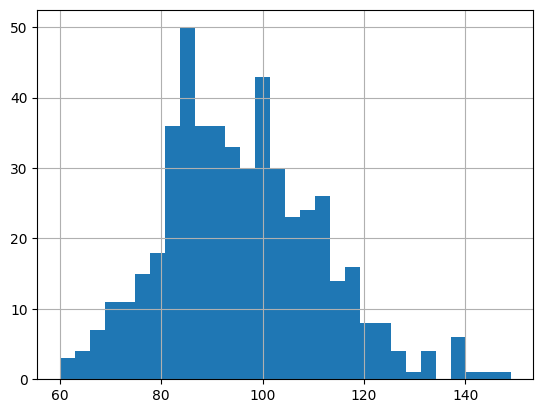

In [32]:
synth["velocity"].hist(bins=30)

In [ ]:
synth["appearance"].value_counts().sort_values(ascending=False)

# Shooters Table

In [ ]:
shooters_df = synth.groupby("shooter")["isgoal"].sum().reset_index(name="total_goals")

# Appearances Table

In [49]:
app_df = (
    synth
    .groupby("appearance")["isgoal"]
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)
app_df = app_df.rename(
    columns={True: "conceded", False: "saved"}
).rename_axis(None, axis=1)
app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   appearance  25 non-null     int64
 1   saved       25 non-null     int64
 2   conceded    25 non-null     int64
dtypes: int64(3)
memory usage: 732.0 bytes


In [50]:
app_df.head(10)

,appearance,saved,conceded
0,0,10,16
1,1,8,11
2,2,8,6
3,3,12,12
4,4,16,9
5,5,7,6
6,6,13,12
7,7,14,11
8,8,16,8
9,9,14,9


In [52]:
n_players = 4

player_ids = np.arange(0, n_players)
player_probs = np.array([0.5, 0.25, 0.15, 0.1], dtype=float)
player_probs = player_probs / player_probs.sum()
app_df["player_id"] = rng.choice(player_ids, size=len(app_df), p=player_probs)

app_df["match_id"] = rng.integers(0, 23, size=len(app_df))

In [53]:
app_df["player_id"].value_counts()

player_id
1    9
0    9
2    7
Name: count, dtype: int64

In [54]:
app_df.head(10)

,appearance,saved,conceded,player_id,match_id
0,0,10,16,1,13
1,1,8,11,2,2
2,2,8,6,2,12
3,3,12,12,0,14
4,4,16,9,1,8
5,5,7,6,1,3
6,6,13,12,1,11
7,7,14,11,2,6
8,8,16,8,0,13
9,9,14,9,1,7


# Players Table

In [57]:
player_df = app_df.groupby("player_id")[["saved", "conceded"]].sum().reset_index()
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   player_id  3 non-null      int64
 1   saved      3 non-null      int64
 2   conceded   3 non-null      int64
dtypes: int64(3)
memory usage: 204.0 bytes


In [58]:
player_df.head()

,player_id,saved,conceded
0,0,108,71
1,1,101,91
2,2,72,57


# Matches Table

In [29]:
match_df = app_df.groupby("match_id")["total_goals"].sum().reset_index(name="conceded")

opponents = ["Fábrica de Azulejos Coentrão", "Comunidade Judaica de Vila Real", "Sporting Clube de Cascos de Rolha", "Associação Desportiva de Cascos de Rolha"]
match_df["opponent"] = rng.choice(opponents, size=len(match_df))

match_df.head(10)

,match_id,conceded,opponent
0,1,6,Fábrica de Azulejos Coentrão
1,2,8,Fábrica de Azulejos Coentrão
2,5,29,Sporting Clube de Cascos de Rolha
3,7,10,Sporting Clube de Cascos de Rolha
4,8,16,Associação Desportiva de Cascos de Rolha
5,11,9,Fábrica de Azulejos Coentrão
6,12,14,Fábrica de Azulejos Coentrão
7,13,7,Sporting Clube de Cascos de Rolha
8,15,7,Fábrica de Azulejos Coentrão
9,16,17,Comunidade Judaica de Vila Real


In [ ]:
with pd.ExcelWriter('output.xlsx') as writer:
    synth.to_excel(writer, sheet_name='Shots', index=False)
    app_df.to_excel(writer, sheet_name='Appearances', index=False)
    player_df.to_excel(writer, sheet_name='Players', index=False)
    match_df.to_excel(writer, sheet_name='Matches', index=False)